In [1]:
#IMPORTS INICIALES
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from autoencoderManager import AutoencoderManager
from fonts import getCharacterMatrix,getCharacterMap,getFormattedFont
from helpers.configHelper import ConfigHelper
from graph import plotErrorAgainstSteps
from noise import addNoise
import pickle
from os.path import exists

# TP5 - Deep Learning

In [2]:
#LEEMOS LOS PARAMETROS DEL CONFIG HELPER

configPath="./config/config.json"
configHelper = ConfigHelper(configPath)
(architecture,encoderActivationFunction,latentSpaceActivationFunction,decoderActivationFunction,encoderBeta,latentSpaceBeta,decoderBeta,learningRate,maxEpochs,maxToleranceExponent,randomSeed,font,noiseProbability) = configHelper.getProperties()

## Ejercicio 1
### a) Autoencoder basico

In [3]:
#PEDIR LA FONT A UTILIZAR Y ARMAR EL TRAINING SET Y RESULT SET
(trainingSet,fontCharacters) = getFormattedFont(font,flatten=True)
resultsSet = trainingSet

In [4]:
# ENTRENAMIENTO DE LA RED
PATH = "autoencoderW7.pickle"
autoencoderManager = AutoencoderManager(architecture,encoderActivationFunction,latentSpaceActivationFunction,decoderActivationFunction,learningRate,maxEpochs)
if exists(PATH):
    print("INITIALIZING WEIGHTS FOR CONFIGURATION")
    file = open(PATH,'rb')
    wFinal = pickle.load(file)
    file.close()
    autoencoderManager.initilizeWeights(trainingSet,wFinal)
else:
    print("CREATING WEIGHTS FOR CONFIGURATION")
    (wFinal,finalError) = autoencoderManager.start(trainingSet)
    file = open(PATH,'wb')
    pickle.dump(wFinal,file)
    file.close()

print(wFinal)
    


CREATING WEIGHTS FOR CONFIGURATION
training matrix (35, 32)


v:\Documents\facu\SIA\SIA-EquipoTermos\TP5\activationFunctions\sigmoidalActivationFunction.py:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(np.multiply(-2*self.beta,h)))


Iteration :  1
	Error :  2.7450892191121934
	Time :  1.3711532999986957
Iteration :  2
	Error :  1.9898015512681784
	Time :  1.48122979999971
Iteration :  3
	Error :  1.676792684873159
	Time :  1.654366000002483
Iteration :  4
	Error :  1.5205183246076497
	Time :  1.5934670999995433
Iteration :  5
	Error :  1.4212351405909702
	Time :  1.651919399999315
Iteration :  6
	Error :  1.3255066258198942
	Time :  1.6221158000007563
Iteration :  7
	Error :  1.2704795521763699
	Time :  1.6827587999978277
Iteration :  8
	Error :  1.2274244164761186
	Time :  1.6674345000028552
Iteration :  9
	Error :  1.1905920995961718
	Time :  1.6993065999995451
Iteration :  10
	Error :  1.133726746437076
	Time :  1.6868420999999216
Iteration :  11
	Error :  1.1099319843546473
	Time :  1.715445699999691
Iteration :  12
	Error :  1.0905815056592159
	Time :  1.6869297999983246
Iteration :  13
	Error :  1.0753441932107002
	Time :  1.7007603000020026
Iteration :  14
	Error :  1.059177766243651
	Time :  1.748691799999

{'X': [-4.245569560193621, -1.708894169390556, -24.216229551066135, -10.086127736873427, -18.98162458440622, -12.340638450527285, -12.897235143416156, -8.63326176701277, -13.432403619201203, 1.9491995896212748, -5.371065777648518, -1.708894169390556, -7.029875639976722, -2.2817839497606274, -4.01367158477997, -7.457947234008849, -18.86169023358883, -4.25997196169804, -12.21744752671447, -22.63211814149413, 0.7368369330506033, -6.9826779999113855, -5.047604349338577, -2.932357779317916, -3.470974057462588, -1.3969982256814306, -11.038223158250318, -27.50455069285491, -3.5347742931846176, -4.472235742443328, -1.2680746024639546, -1.1526426912645467], 'Y': [-1.4137400497655062, -1.6772590145885937, -22.143467902854876, -5.684709699359015, -14.338346290867584, -11.978537758946946, -16.19955427183041, -3.635584868429735, -21.357868998642072, -4.785045530684831, 0.4772729058432774, -1.6772590145885937, -5.839648465788343, -2.0688108547306445, -7.2800625814133895, -4.441622272411843, -19.5785

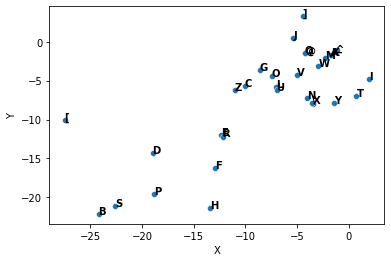

In [5]:
# LATENT SPACE CONFIGURATION
latentSpaceData = {
    'X' : [],
    'Y' : [],
    'Label':[]
}
i=0
for character in trainingSet:
    point = autoencoderManager.getLatentSpaceConfig(character)
    latentSpaceData['X'].append(point[0])
    latentSpaceData['Y'].append(point[1])
    latentSpaceData['Label'].append(fontCharacters[i])
    i+=1
data = pd.DataFrame(latentSpaceData)
print(latentSpaceData)
sp = sns.scatterplot(x="X",y="Y",data=data)
for c in range(0,data.shape[0]):
    sp.text(data.iloc[c]['X'],data.iloc[c]['Y'],data.iloc[c]['Label'],fontsize=10,horizontalalignment='left',weight='bold')

In [13]:
autoencoderManager.saveNetwork('30-10-2.json', autoencoderManager.errors)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


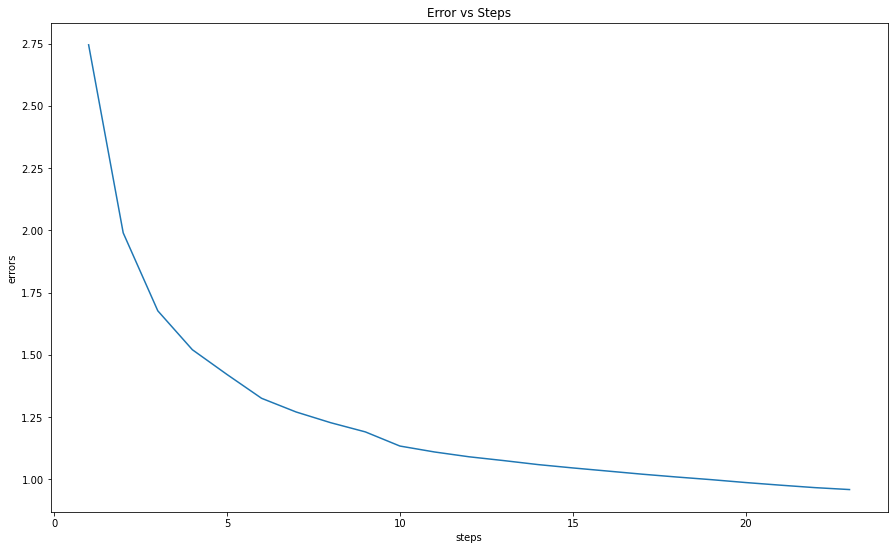

In [7]:
#GRAFICAR ERROR VS STEPS
plotErrorAgainstSteps(autoencoderManager.errors,autoencoderManager.steps)
print(autoencoderManager.steps)

In [11]:
(autoencoderManager,errors) = AutoencoderManager.networkFromFile('35-20-3_errors.json' )

TypeError: AutoencoderManager.networkFromFile() takes 2 positional arguments but 3 were given

[[[0 1 1 1 0]
  [1 0 0 0 1]
  [1 0 1 1 1]
  ...
  [1 0 1 1 1]
  [1 0 0 0 0]
  [0 1 1 1 1]]

 [[0 0 1 0 0]
  [0 1 0 1 0]
  [1 0 0 0 1]
  ...
  [1 1 1 1 1]
  [1 0 0 0 1]
  [1 0 0 0 1]]

 [[1 1 1 1 0]
  [1 0 0 0 1]
  [1 0 0 0 1]
  ...
  [1 0 0 0 1]
  [1 0 0 0 1]
  [1 1 1 1 0]]

 ...

 [[0 1 1 1 0]
  [0 0 0 1 0]
  [0 0 0 1 0]
  ...
  [0 0 0 1 0]
  [0 0 0 1 0]
  [0 1 1 1 0]]

 [[0 0 1 0 0]
  [0 1 0 1 0]
  [1 0 0 0 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [1 1 1 1 1]]]


v:\Documents\facu\SIA\SIA-EquipoTermos\TP5\activationFunctions\sigmoidalActivationFunction.py:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(np.multiply(-2*self.beta,h)))


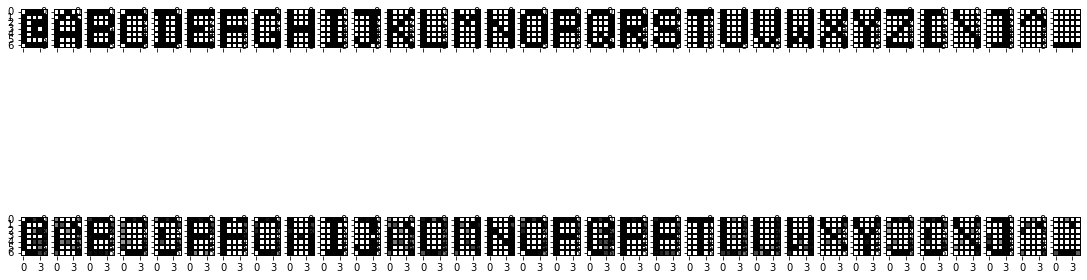

In [8]:
# PLOT INPUT VS OUTPUT OF FINAL LAYER
(formattedFont,fontCharacters) = getFormattedFont(font,flatten=False)
print(formattedFont)
figure, axes = plt.subplots( 2,len(formattedFont), sharex=True, figsize=(19,7))
for font in range(0,len(formattedFont)):
    getCharacterMap(formattedFont[font],ax=axes[0,font])
    umbralFormattedCharacter = [x if x>=0.35 else 0 for x in autoencoderManager.propagate(trainingSet[font])]
    getCharacterMap(getCharacterMatrix(np.array(umbralFormattedCharacter)),ax=axes[1,font])

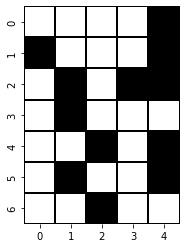

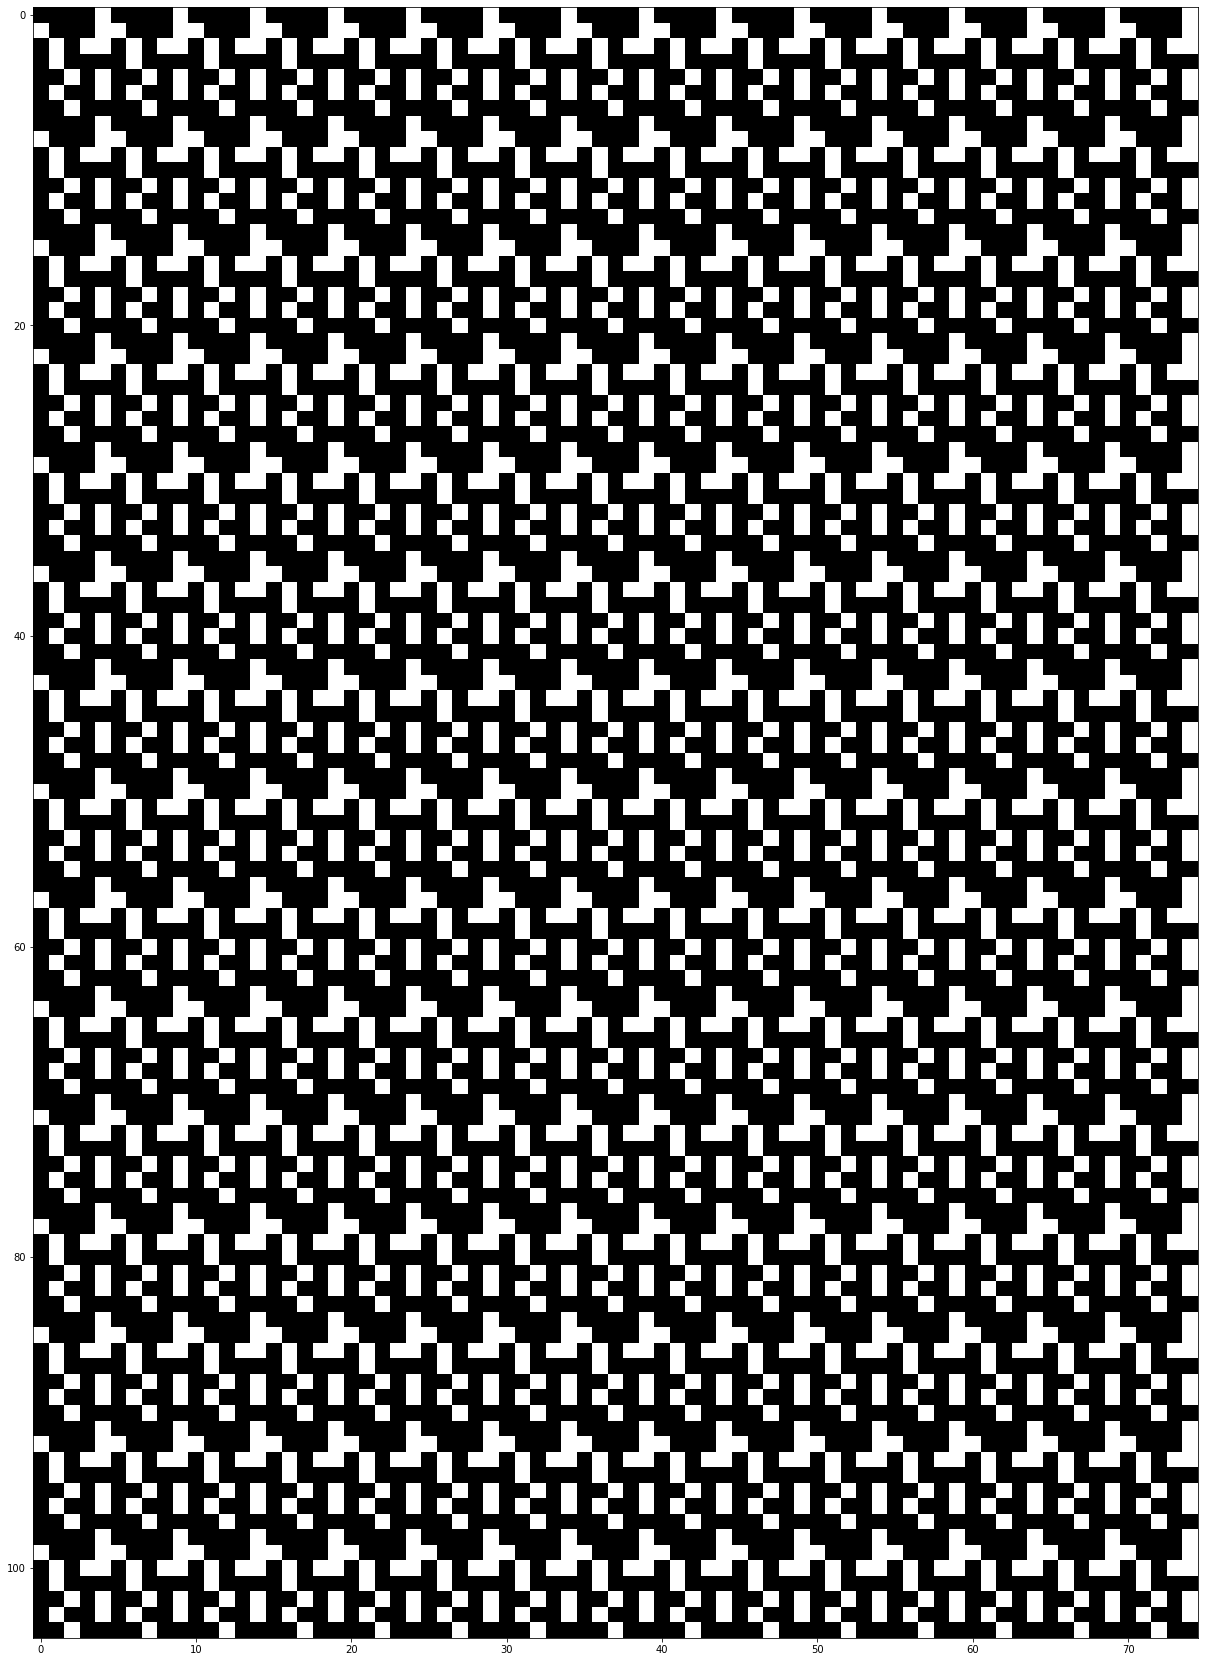

In [7]:
n = 15  # figure with 15x15 digits
width_digit_size = 5
height_digit_size = 7
figure = np.zeros((height_digit_size * n, width_digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = np.linspace(0, 1, n)
grid_y = np.linspace(0, 1, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = autoencoderManager.decodeFromLatentSpace(z_sample)
        digit = x_decoded.reshape(height_digit_size, width_digit_size)
        getCharacterMap(digit)
        figure[i * height_digit_size: (i + 1) * height_digit_size,
               j * width_digit_size: (j + 1) * width_digit_size] = digit

plt.figure(figsize=(30, 30))
plt.imshow(figure, cmap='Greys_r')
plt.show()

### b) Denoising autoencoder

In [ ]:
#ARMAMOS TRAINING SET CON RUIDO Y EL NUEVO RESULTS SET

#Seteo de seed
np.random.seed(randomSeed)
random.seed(randomSeed)

numberOfElements = 5
#Agarramos las 10 primeras letras de la font
flattenedSubFont = getFormattedFont(font,flatten=True)[:numberOfElements]
# noiseProbability = 0.1
numberOfSubFonts = 5
#Armamos el trainingSet colocando las letras con distinto ruido segun la probabilidad especificada, y el resultsSet con las letras sin ruido
newTrainingSet = []
newResultsSet = []
# for i in range(0,numberOfSubFonts):
#     for j in range(0,len(flattenedSubFont)):
#         newTrainingSet.append(addNoise(flattenedSubFont[j],noiseProbability))
#         newResultsSet.append(flattenedSubFont[j])
for j in range(0,len(flattenedSubFont)):
    for i in range(0,numberOfSubFonts):
        newTrainingSet.append(addNoise(flattenedSubFont[j],noiseProbability))
        newResultsSet.append(flattenedSubFont[j])


newTrainingSet = np.asarray(newTrainingSet)
newResultsSet = np.asarray(newResultsSet)


In [ ]:
# IMPRIMIMOS EL TRAINING SET Y EL RESULTS SET
figure, axes = plt.subplots( 2,len(newTrainingSet), sharex=True, figsize=(19,7))
for i in range(0,len(newTrainingSet)):
    # print(newTrainingSet[i])
    umbralTrainingFormattedCharacter = [x if x>=0.35 else 0 for x in newTrainingSet[i]]
    getCharacterMap(getCharacterMatrix(np.array(umbralTrainingFormattedCharacter)),ax=axes[0,i])
    umbralResultFormattedCharacter = [x if x>=0.35 else 0 for x in newResultsSet[i]]
    getCharacterMap(getCharacterMatrix(np.array(umbralResultFormattedCharacter)),ax=axes[1,i])

    # getCharacterMap(formattedFont[font],ax=axes[0,font])
    # umbralFormattedCharacter = [x if x>=0.35 else 0 for x in autoencoderManager.propagate(trainingSet[font])]
    # getCharacterMap(getCharacterMatrix(np.array(umbralFormattedCharacter)),ax=axes[1,font])

In [ ]:
#ENTRENAMIENTO DE LA RED

denoisingAutoencoderManager = AutoencoderManager(architecture,encoderActivationFunction,latentSpaceActivationFunction,decoderActivationFunction,learningRate,maxEpochs)
(wFinal,finalError) = denoisingAutoencoderManager.start(newTrainingSet,newResultsSet)

In [ ]:
#TESTEO DE LA RED
#Generamos un nuevo set de letras con ruido
noiseSet = []
resultsSet = flattenedSubFont
for j in range(0,len(flattenedSubFont)):
        noiseSet.append(addNoise(flattenedSubFont[j],noiseProbability))
noiseSet = np.asarray(noiseSet)
#Comparamos el input ruidoso con la salida de la red
figure, axes = plt.subplots( 2,len(noiseSet), sharex=True, figsize=(19,7))
for i in range(0,len(noiseSet)):
    umbralTrainingFormattedCharacter = [x if x>=0.35 else 0 for x in noiseSet[i]]
    getCharacterMap(getCharacterMatrix(np.array(umbralTrainingFormattedCharacter)),ax=axes[0,i])
#     umbralResultFormattedCharacter = [x if x>=0.35 else 0 for x in newResultsSet[i]]
#     getCharacterMap(getCharacterMatrix(np.array(umbralResultFormattedCharacter)),ax=axes[1,i])
#     getCharacterMap(formattedFont[font],ax=axes[0,font])
    umbralResultFormattedCharacter = [x if x>=0.35 else 0 for x in denoisingAutoencoderManager.propagate(noiseSet[i])]
    getCharacterMap(getCharacterMatrix(np.array(umbralResultFormattedCharacter)),ax=axes[1,i])